# Aufgabe 1 - Akku-Abenteuer: Tobi's Optimale Routenplanung

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird.

Diese Zelle enthält alle Funktionen / Klassen, die für die folgenden Aufgaben benötigt werden

In [1]:
from typing import List, Optional, Tuple
from queue import PriorityQueue
from PIL import Image, ImageDraw
import numpy as np
from IPython.display import display_png


ROW_COL_CNT = 21
SPILLED = False


class TileColor:
    """
    Defines the colors for each tile type
    """

    WALL = (0, 0, 0, 255)
    OUTSIDE = (255, 255, 255, 0)
    FLOOR = (200, 113, 55, 255)
    TEA_KITCHEN = (0, 0, 255, 255)
    PROFESSOR_OFFICE = (0, 255, 0, 255)
    LABOR = (255, 255, 0, 255)


class TileType:
    """
    The string representation for each tile
    """

    WALL = 'wall'
    OUTSIDE = 'outside'
    FLOOR = 'floor'
    TEA_KITCHEN = 'tea_kitchen'
    PROFESSOR_OFFICE = 'professor_office'
    LABOR = 'labor'

    @staticmethod
    def of(pixel: tuple):
        """
        Pixel to tile type
        """

        return {
            TileColor.WALL: TileType.WALL,
            TileColor.OUTSIDE: TileType.OUTSIDE,
            TileColor.FLOOR: TileType.FLOOR,
            TileColor.TEA_KITCHEN: TileType.TEA_KITCHEN,
            TileColor.PROFESSOR_OFFICE: TileType.PROFESSOR_OFFICE,
            TileColor.LABOR: TileType.PROFESSOR_OFFICE,
        }[pixel]


class TileCost:
    """
    Tile costs for the algorithms
    """

    WALL = 1
    OUTSIDE = 1
    FLOOR = 2
    TEA_KITCHEN = 3
    PROFESSOR_OFFICE = 4
    LABOR = 5

    @staticmethod
    def of(tile: TileType):
        """
        Pixel to tile type
        """

        return {
            TileType.WALL: TileCost.WALL,
            TileType.OUTSIDE: TileCost.OUTSIDE,
            TileType.FLOOR: TileCost.FLOOR,
            TileType.TEA_KITCHEN: TileCost.TEA_KITCHEN,
            TileType.PROFESSOR_OFFICE: TileCost.PROFESSOR_OFFICE,
            TileType.LABOR: TileCost.PROFESSOR_OFFICE,
        }[tile]


class Node:
    """
    To build a search tree.
    The cost parameter is used to order the nodes in the priority queue.
    In case of A* this must contain the already accumulated cost + the heuristics expected cost.
    """

    def __init__(self, parent: Optional['Node'], position: Tuple[int, int], cost=0, **kwargs):
        self.parent = parent
        self.position = position
        self.children = list()
        self.cost = cost
        self.additional_data = dict(kwargs)

    def add_child(self, node):
        """ Adds a new child to the node """
        self.children.append(node)

    def __gt__(self, other: 'Node'):
        """ Must be comparable for the priority queue """
        return self.cost > other.cost

    def __lt__(self, other: 'Node'):
        """ Must be comparable for the priority queue """
        return self.cost < other.cost

    def __eq__(self, o: 'Node') -> bool:
        """ Simple equality comparison """
        if not isinstance(o, Node):
            return False

        return self.position == o.position and self.parent == o.parent and self.cost == o.cost

    def __repr__(self):
        return f'Node({self.position}, {self.cost})'


class NodeIterator:
    """
    Provides the basic structure for the graph search algorithms
    """

    ADJ_VECTORS = [(-1, 0), (0, 1), (1, 0), (0, -1)]  # For finding adjacent fields
    START = (3, 17)
    END = (1, 3)
    MX = ROW_COL_CNT
    MY = ROW_COL_CNT

    def __init__(self, allow_revisit=False, print_stats=True, allow_go_back=False):
        """
        :param allow_revisit: If True, tiles can be visited multiple times
        :param print_stats  : If True, prints some search stats in the end of execution
        :param allow_go_back: If True, allows visiting the parent node
        """

        self._queue: PriorityQueue[Node] = PriorityQueue()
        self._allow_revisit = allow_revisit
        self._print_stats = print_stats
        self._allow_go_back = allow_go_back
        self.root = Node(None, self.START)
        self._visited = set()
        self._plan_matrix = parse_image()

    def run(self) -> Tuple[int, List[Node]]:
        """
        Performs the graph search
        :return: (Amount of visited nodes, The calculated path)
        """

        cnt = 0     # Amount of visited nodes
        self._queue.put(self.modify_new_node(self.root))
        # noinspection PyTypeChecker
        node: Node = None

        # Iterate over the non-processed nodes
        while not self._queue.empty():
            node = self._queue.get()
            node_x, node_y = node.position

            if not self._allow_revisit:
                self._visited.add(node.position)

            # Enqueue neighbours
            for adj_vec in self.ADJ_VECTORS:
                next_x, next_y = node_x + adj_vec[0], node_y + adj_vec[1]

                # Don't re-visit
                if not self._allow_revisit and (next_x, next_y) in self._visited:
                    continue

                # Don't visit parent
                if not self._allow_go_back and node.parent and node.parent.position == (next_x, next_y):
                    continue

                # Check if node is in range
                if next_x < 0 or next_x > self.MX or next_y < 0 or next_y > self.MY:
                    continue

                # Don't go through walls
                node_type = self._plan_matrix[next_x, next_y]
                if node_type == TileType.WALL:
                    continue

                child_node = self.modify_new_node(Node(node, (next_x, next_y)))
                node.add_child(child_node)
                self._queue.put(child_node)

            cnt += 1

            # Stop when target is reached
            if (node_x, node_y) == self.END:
                break

        # Construct the path from start to finish
        path = list()
        parent = node
        while parent is not None:
            path.insert(0, parent)
            parent = parent.parent

        if self._print_stats:
            print(f'Searched nodes : {cnt}')
            print(f'Solution length: {len(path)}')
            print(f'Shortest path  : ' + ' -> '.join(map(str, [n.position for n in path])))

        return cnt, path

    def modify_new_node(self, node: Node) -> Node:
        """
        This method can be overridden by subclasses to modify newly created / visited nodes.
        This is mainly used to define the nodes cost.
        """
        return node

    def __repr__(self):
        return f'{self.__class__.__name__}()'


def parse_image() -> np.matrix:
    """
    Parses the image and creates a matrix of tile types.
    """

    img = Image.open('lageplan.png')
    cell_size = 420 / ROW_COL_CNT
    plan_matrix = list()

    for i in range(ROW_COL_CNT):
        row = list()
        for j in range(ROW_COL_CNT):
            # Get one pixel for each tile. x, y have an offset of 10 to get the color of the tile
            # and not of the border
            pixel = img.getpixel((int(i * cell_size + 10), int(j * cell_size + 10)))
            row.append(TileType.of(pixel))
        plan_matrix.append(row)

    img.close()
    return np.matrix(plan_matrix)


def draw_on_image(path: List[Node]):
    """
    Draws the taken path onto the input image
    """

    img = Image.open('lageplan.png')
    draw = ImageDraw.Draw(img)

    cell_size = 420 / ROW_COL_CNT

    for node in path:
        point = node.position
        x = point[0] * cell_size + 4
        y = point[1] * cell_size + 4
        draw.ellipse((x, y, x + 11, y + 11), fill='white', outline='blue')

    display_png(img)



## Teilaufgabe a): lageplan.png laden und verarbeiten

In [2]:
# This method is used later on, so this call is only here for completeness
parse_image()

matrix([['outside', 'outside', 'wall', 'wall', 'wall', 'wall', 'wall',
         'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall',
         'wall', 'wall', 'wall', 'wall', 'wall', 'wall'],
        ['outside', 'outside', 'wall', 'professor_office',
         'professor_office', 'professor_office', 'floor', 'floor',
         'wall', 'professor_office', 'professor_office',
         'professor_office', 'wall', 'floor', 'floor', 'floor', 'floor',
         'floor', 'floor', 'floor', 'wall'],
        ['wall', 'wall', 'wall', 'professor_office', 'wall', 'wall',
         'wall', 'floor', 'wall', 'professor_office', 'wall', 'wall',
         'wall', 'floor', 'wall', 'wall', 'wall', 'tea_kitchen', 'wall',
         'floor', 'wall'],
        ['wall', 'floor', 'floor', 'floor', 'floor', 'floor', 'floor',
         'floor', 'floor', 'floor', 'floor', 'floor', 'floor', 'floor',
         'floor', 'wall', 'professor_office', 'tea_kitchen', 'wall',
         'floor', 'wall'],
        ['wall', 'f

## Teilaufgabe b): Breitensuche

--- BFS ---
Searched nodes : 91
Solution length: 21
Shortest path  : (3, 17) -> (3, 16) -> (4, 16) -> (5, 16) -> (5, 15) -> (5, 14) -> (4, 14) -> (3, 14) -> (3, 13) -> (3, 12) -> (3, 11) -> (3, 10) -> (3, 9) -> (3, 8) -> (3, 7) -> (3, 6) -> (3, 5) -> (3, 4) -> (3, 3) -> (2, 3) -> (1, 3)


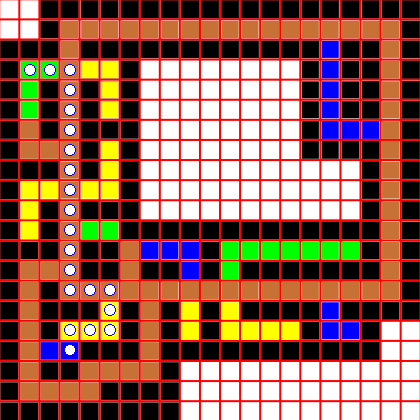

In [3]:
class BFSNodeIterator(NodeIterator):
    """
    Does Breadth-first search
    """

    def modify_new_node(self, node: Node) -> Node:
        """
        Not adding any cost will result in the nodes getting processed in insertion order
        """
        return node

print('--- BFS ---')
bfs = BFSNodeIterator(allow_revisit=False, print_stats=True)
_, path = bfs.run()
draw_on_image(path)

## Teilaufgabe c): A*-Algorithmus

--- A* ---
Searched nodes : 533
Solution length: 53
Shortest path  : (3, 17) -> (3, 16) -> (4, 16) -> (5, 16) -> (5, 15) -> (5, 14) -> (6, 14) -> (7, 14) -> (8, 14) -> (9, 14) -> (10, 14) -> (11, 14) -> (12, 14) -> (13, 14) -> (14, 14) -> (15, 14) -> (16, 14) -> (17, 14) -> (18, 14) -> (19, 14) -> (19, 13) -> (19, 12) -> (19, 11) -> (19, 10) -> (19, 9) -> (19, 8) -> (19, 7) -> (19, 6) -> (19, 5) -> (19, 4) -> (19, 3) -> (19, 2) -> (19, 1) -> (18, 1) -> (17, 1) -> (16, 1) -> (15, 1) -> (14, 1) -> (13, 1) -> (12, 1) -> (11, 1) -> (10, 1) -> (9, 1) -> (8, 1) -> (7, 1) -> (6, 1) -> (5, 1) -> (4, 1) -> (3, 1) -> (3, 2) -> (3, 3) -> (2, 3) -> (1, 3)


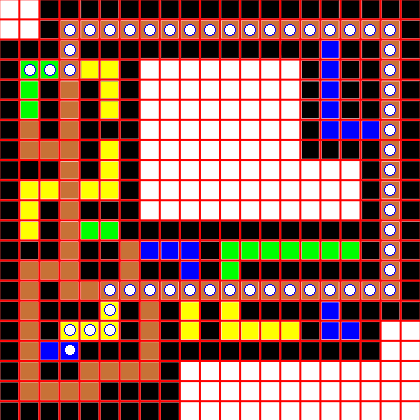

In [10]:
def get_cost(plan_matrix: np.matrix, point: Tuple[int, int]) -> int:
    if SPILLED and point[0] == 3 and 3 <= point[1] <= 14:
        return 20
    else:
        return TileCost.of(plan_matrix[point])

def manhattan_heuristic(plan_matrix: np.matrix, pos: tuple, end: tuple):
    """
    Goes directly to the end position and measures the cost of each visited tile.
    The heuristic is valid and consistent.

    :param plan_matrix: The location plan
    :param pos: Current position
    :param end: Target position
    :return: The cost
    """

    return abs(end[0] - pos[0]) + abs(end[1] - pos[1]) * 5

    sign = lambda x: -1 if x < 0 else 1
    cost = 0
    point = pos

    while point != end:
        x_diff = end[0] - point[0]
        y_diff = end[1] - point[1]

        if abs(x_diff) > abs(y_diff):
            x_increment = sign(x_diff)
            point = (point[0] + x_increment, point[1])
        else:
            y_increment = sign(y_diff)
            point = (point[0], point[1] + y_increment)

        cost += get_cost(plan_matrix, point)

    return cost

class AStarNodeIterator(NodeIterator):
    """
    Does A* serach
    """

    def __init__(self, print_stats=True):
        super().__init__(True, print_stats, False)

    def modify_new_node(self, node: Node) -> Node:
        """
        Get the currently used cost (from the parent node) and add the expected cost (from the heuristic)
        to create this nodes cost.
        Note: 'node.cost' is the cost used by the algorithm and not the cost of the path to the node.
        """

        current_cost = node.parent.additional_data.get('current_cost', 0) if node.parent else 0
        node.cost = current_cost + manhattan_heuristic(self._plan_matrix, node.position, self.END)
        node.additional_data['current_cost'] = current_cost + get_cost(self._plan_matrix, node.position)
        return node

print('--- A* ---')
astar = AStarNodeIterator(print_stats=True)
_, path = astar.run()
draw_on_image(path)

## Teilaufgabe d): Greedy Best First Search-Algorithmus

--- Greedy-Best-First Search ---
Searched nodes : 21
Solution length: 21
Shortest path  : (3, 17) -> (3, 16) -> (4, 16) -> (5, 16) -> (5, 15) -> (5, 14) -> (4, 14) -> (3, 14) -> (3, 13) -> (3, 12) -> (3, 11) -> (3, 10) -> (3, 9) -> (3, 8) -> (3, 7) -> (3, 6) -> (3, 5) -> (3, 4) -> (3, 3) -> (2, 3) -> (1, 3)


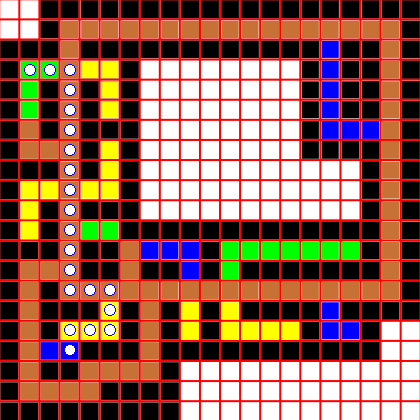

In [15]:
class GreedyBestFirstSearchNodeIterator(NodeIterator):
    """
    Does Greedy-best-first search
    """

    def modify_new_node(self, node: Node) -> Node:
        """
        Just uses the heuristic as cost
        """

        node.cost = manhattan_heuristic(self._plan_matrix, node.position, self.END)
        return node

print('--- Greedy-Best-First Search ---')
greedy = GreedyBestFirstSearchNodeIterator(allow_revisit=True, print_stats=True)
_, path = greedy.run()
draw_on_image(path)

## Teilaufgabe e): Dusseliger Doktorand

--- Greedy-Best-First Search 2 ---
Searched nodes : 21
Solution length: 21
Shortest path  : (3, 17) -> (3, 16) -> (4, 16) -> (5, 16) -> (5, 15) -> (5, 14) -> (4, 14) -> (3, 14) -> (3, 13) -> (3, 12) -> (3, 11) -> (3, 10) -> (3, 9) -> (3, 8) -> (3, 7) -> (3, 6) -> (3, 5) -> (3, 4) -> (3, 3) -> (2, 3) -> (1, 3)


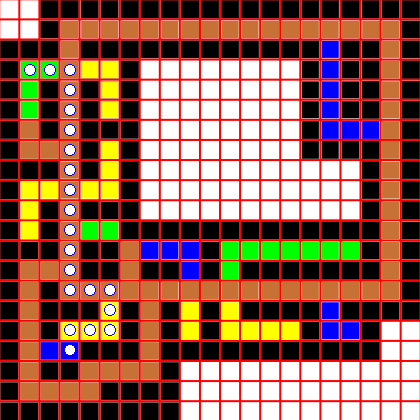

--- A* 2 ---
Searched nodes : 533
Solution length: 53
Shortest path  : (3, 17) -> (3, 16) -> (4, 16) -> (5, 16) -> (5, 15) -> (5, 14) -> (6, 14) -> (7, 14) -> (8, 14) -> (9, 14) -> (10, 14) -> (11, 14) -> (12, 14) -> (13, 14) -> (14, 14) -> (15, 14) -> (16, 14) -> (17, 14) -> (18, 14) -> (19, 14) -> (19, 13) -> (19, 12) -> (19, 11) -> (19, 10) -> (19, 9) -> (19, 8) -> (19, 7) -> (19, 6) -> (19, 5) -> (19, 4) -> (19, 3) -> (19, 2) -> (19, 1) -> (18, 1) -> (17, 1) -> (16, 1) -> (15, 1) -> (14, 1) -> (13, 1) -> (12, 1) -> (11, 1) -> (10, 1) -> (9, 1) -> (8, 1) -> (7, 1) -> (6, 1) -> (5, 1) -> (4, 1) -> (3, 1) -> (3, 2) -> (3, 3) -> (2, 3) -> (1, 3)


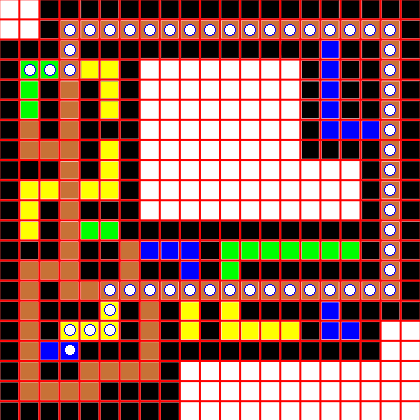

In [14]:
SPILLED = True

print('--- Greedy-Best-First Search 2 ---')
greedy = GreedyBestFirstSearchNodeIterator(allow_revisit=True, print_stats=True)
_, path = greedy.run()
draw_on_image(path)

print('--- A* 2 ---')
astar = AStarNodeIterator(print_stats=True)
_, path = astar.run()
draw_on_image(path)